<a href="https://colab.research.google.com/github/Smoulvad01/AI-C1-image-/blob/main/Image_Analysis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <font color='green'>Import</font>

In [16]:
import cv2
from PIL import Image # To display images
from sklearn.decomposition import NMF, PCA

# TensorFlow and tf.keras
import tensorflow as tf
from keras.utils.vis_utils import plot_model

# Helper libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from sklearn.pipeline import Pipeline
import os
from livelossplot import PlotLossesKeras

# load models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# metrics and evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

reload(plt)
np.set_printoptions(suppress=True)
print(tf.__version__)




2.12.0


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <font color='green'>Load and Process the Data</font>

In [24]:
# Use this if working in Jupyter Notebook (not Colab)
directory_train = "/content/drive/MyDrive/dataset_new/train"
directory_test = "/content/drive/MyDrive/dataset_new/test"

In [22]:
def load_image_dataset(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='grayscale',
        batch_size=32,
        image_size=(256, 256),
        shuffle=True,
        seed=42,
        validation_split=False,
        interpolation='mitchellcubic',
        follow_links=False,
        crop_to_aspect_ratio=False,
    )
    return dataset

In [32]:
# COPY TO INSPECT AND PROCESSING
train_images = load_image_dataset(directory_train)
test_images = load_image_dataset(directory_test)

Found 1234 files belonging to 2 classes.
Found 218 files belonging to 2 classes.


In [29]:
#MOVE TO INSPECT AND PROCESSING
#Checking what the train test split is: 
train_size = 1234
test_size = 218

print(test_size/(train_size+test_size))

0.15013774104683195


In [30]:
#COPY TO INSPECT AND PROCESSING
# labeling to give classnames 
class_names = train_images.class_names
print(class_names)

['Closed', 'Open']


In [31]:
#MOVE TO INSPECTION
# get the count of elements in the batched datasets
from collections import Counter

counter = Counter()

for images, labels in train_images:
    # Count the labels in this batch
    counter.update(labels.numpy())

# Print the counts of each class
for class_index, count in counter.items():
    print(f"Class {train_images.class_names[class_index]}: {count}")

Class Open: 617
Class Closed: 617


# <font color='GREEN'>Build Models</font>

# <font color='blue'> Define X_train, y_train and PCA </font>

In [ ]:
# Initialize lists to store the images and labels
train_images_list = []
train_labels_list = []

# Iterate over the dataset
for images, labels in train_images:
    # Flatten the images
    flat_images = tf.reshape(images, (images.shape[0], -1)).numpy()
    # Append the images and labels to the lists
    train_images_list.append(flat_images)
    train_labels_list.append(labels.numpy())

# Concatenate the list of arrays into a single numpy array
X_train = np.concatenate(train_images_list)
y_train = np.concatenate(train_labels_list)

In [ ]:
# Initialize lists to store the images and labels
test_images_list = []
test_labels_list = []

# Iterate over the dataset
for images, labels in test_images:
    # Flatten the images
    flat_images = tf.reshape(images, (images.shape[0], -1)).numpy()
    # Append the images and labels to the lists
    test_images_list.append(flat_images)
    test_labels_list.append(labels.numpy())

# Concatenate the list of arrays into a single numpy array
X_test = np.concatenate(test_images_list)
y_test = np.concatenate(test_labels_list)

In [ ]:
pca = PCA(
    n_components=50,
    whiten=True, 
    random_state=0
)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

f"X_train_pca.shape: {X_train_pca.shape}"

# USE THIS TEST AND TRAIN DATA WHEN CODE BELOW WORKS

'X_train_pca.shape: (1234, 50)'

# <font color='blue'> Dummy Classifier </font>

In [ ]:
# Train and evaluate a DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
print("Dummy Classifier accuracy: %f" % accuracy_score(y_test, y_pred_dummy))

print("Accuracy on training set: {:.3f}".format(dummy.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dummy.score(X_test, y_test)))

Dummy Classifier accuracy: 0.500000
Accuracy on training set: 0.500
Accuracy on test set: 0.500


# <font color='blue'> Logistic Regression & KNN </font>

In [ ]:
# Defining the pipeline for Logistic Regression
pipe_log_reg = Pipeline([
    ("clf", LogisticRegression(max_iter=1000))
])

params_log_reg = { 
    "clf__C": [0.001, 0.01, 0.1, 1],
}

# Perform GridSearchCV for Logistic Regression
grid_search_log_reg = GridSearchCV(pipe_log_reg, params_log_reg, verbose=2, cv=3)
grid_search_log_reg.fit(X_train, y_train)

# Print the best parameters and score for Logistic Regression
print(f"Best score (Logistic Regression): {grid_search_log_reg.best_score_:.3f}")
print("Best parameters set (Logistic Regression):")
best_parameters_log_reg = grid_search_log_reg.best_estimator_.get_params()
for param_name in sorted(params_log_reg.keys()):
    print(f"\t{param_name}: {best_parameters_log_reg[param_name]}")

# Print the accuracy scores for Logistic Regression
print("Train (Logistic Regression)", grid_search_log_reg.score(X_train, y_train))
print("Test (Logistic Regression)", grid_search_log_reg.score(X_test, y_test))

# Defining the pipeline for KNeighborsClassifier
pipe_knn = Pipeline([
    ("clf", KNeighborsClassifier())
])

params_knn = {
    "clf__n_neighbors": np.arange(1,20),
    "clf__metric": ["euclidean"],
    "clf__weights": ["uniform", "distance"]
}

# Perform GridSearchCV for KNeighborsClassifier
grid_search_knn = GridSearchCV(pipe_knn, params_knn, verbose=2, cv=3)
grid_search_knn.fit(X_train, y_train)

# Print the best parameters and score for KNeighborsClassifier
print(f"Best score (KNN): {grid_search_knn.best_score_:.3f}")
print("Best parameters set (KNN):")
best_parameters_knn = grid_search_knn.best_estimator_.get_params()
for param_name in sorted(params_knn.keys()):
    print(f"\t{param_name}: {best_parameters_knn[param_name]}")

# Print the accuracy scores for KNeighborsClassifier
print("Train (KNN)", grid_search_knn.score(X_train, y_train))
print("Test (KNN)", grid_search_knn.score(X_test, y_test))

figure out how to use this for evaluation and confusion matrix

# <font color='blue'> CNN </font>

In [ ]:
##Best performance until now

# Load a convolutional base with pre-trained weights
base_model = tf.keras.applications.MobileNet(
    weights='imagenet',  # Pre-trained on ImageNet
    include_top=False,  # Do not include the ImageNet classifier at the top
    pooling='avg')  # Global average pooling applied after the last convolutional block

# Freeze the base model
base_model.trainable = False

# Add a new classifier layers on top
model = tf.keras.Sequential([
    base_model,  # The base model
    tf.keras.layers.Dense(224, activation='relu'),  # Dense layer with 256 units
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),  # Binary classification so only 1 output unit with sigmoid activation
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define number of epochs
num_epochs = 10

# Train the model
history = model.fit(train_images, 
                    epochs=num_epochs)
                #    validation_data=test_images)

Epoch 1/10
39/39 [==============================] - 23s 514ms/step - loss: 0.3382 - accuracy: 0.8525
Epoch 2/10
39/39 [==============================] - 22s 546ms/step - loss: 0.0980 - accuracy: 0.9716
Epoch 3/10
39/39 [==============================] - 31s 763ms/step - loss: 0.0608 - accuracy: 0.9846
Epoch 4/10
39/39 [==============================] - 29s 718ms/step - loss: 0.0462 - accuracy: 0.9878
Epoch 5/10
39/39 [==============================] - 25s 622ms/step - loss: 0.0368 - accuracy: 0.9911
Epoch 6/10
39/39 [==============================] - 24s 601ms/step - loss: 0.0275 - accuracy: 0.9927
Epoch 7/10
39/39 [==============================] - 25s 604ms/step - loss: 0.0247 - accuracy: 0.9968
Epoch 8/10
39/39 [==============================] - 24s 589ms/step - loss: 0.0191 - accuracy: 0.9959
Epoch 9/10
39/39 [==============================] - 18s 448ms/step - loss: 0.0182 - accuracy: 0.9968
Epoch 10/10
39/39 [==============================] - 24s 599ms/step - loss: 0.0168 - accura

In [ ]:
predictions = model.predict(test_images)

results = model.evaluate(test_images)
print(f"Test score: {results}")
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

7/7 [==============================] - 4s 473ms/step - loss: 0.0345 - accuracy: 0.9908
Test score: [0.03449578955769539, 0.9908257126808167]
The current model achieved a categorical accuracy of 99.08%!


In [ ]:
from sklearn.metrics import classification_report
import numpy 

predicted_classes = np.where(predictions>0.5, 1, 0)
class_labels = ['class0', 'class1']  # replace with your actual class names
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)



              precision    recall  f1-score   support

      class0       0.49      0.49      0.49       109
      class1       0.49      0.49      0.49       109

    accuracy                           0.49       218
   macro avg       0.49      0.49      0.49       218
weighted avg       0.49      0.49      0.49       218



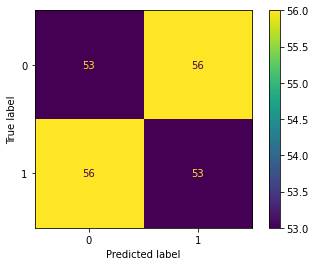

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            )
disp.plot()
plt.show()

# <font color='green'>Evaluate the Model - Revisit this </font>

In [ ]:
#Precision, recall, and F1 score (classification report):
print(classification_report(y_test, model_pred))

In [ ]:
# Use predict_proba 
# revisit class 2 solutions for 
#     probas = knn2.predict_proba(X_test)
#plot the result using plt.hist(probas[:, 1])
#     plt.hist(probas[:, 1])

In [ ]:
# print confusion matrix for simple models 
# MOVE CNN MATRIX DOWN HERE LATER 
cm = confusion_matrix(y_test, model_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=dm.classes_)
disp.plot()
plt.show()

# <font color='red'>Make Prediction - Revisit this</font>

In [ ]:
probability_model = tf.keras.Sequential(
    [
        model, 
        tf.keras.layers.Softmax()
    ]
)

In [ ]:
plot_model(
    probability_model, 
    show_shapes=True, 
    show_dtype=True,
    show_layer_names=True, 
    show_layer_activations=True
)

In [ ]:
predictions = probability_model.predict(test_images)

In [ ]:
predictions[0]

In [ ]:
i = random.choice(range(predictions.shape[0]))
pred = np.argmax(predictions[i])
f"Higest probability for class: {pred} ({FASHION_CLASS_NAMES[pred]}) | Correct label: {test_labels[i]} ({FASHION_CLASS_NAMES[test_labels[i]]})"

In [ ]:
#Examining the test label shows that this classification is correct:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel(f"{FASHION_CLASS_NAMES[predicted_label]} {100*np.max(predictions_array):2.0f}% ({FASHION_CLASS_NAMES[true_label]})", color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(FASHION_CLASS_NAMES)), FASHION_CLASS_NAMES, size='small', rotation=30)
  plt.yticks(range(100))
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# <font color='red'>VERIFY PREDICTIONS - REVISIT THIS</font>

In [ ]:
i = random.choice(range(predictions.shape[0]))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*4*num_cols, 3*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

# <font color='red'>USE THE TRAINED MODEL - REVISIT THIS</font>

In [ ]:
# Grab an image from the test dataset.
i = random.choice(range(test_images.shape[0]))
img = test_images[i]

print(img.shape)

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

In [ ]:
#PREDICT THE CORRECT LABEL
predictions_single = probability_model.predict(img)

print(predictions_single)

In [ ]:
plot_value_array(
    i, 
    predictions_single[0], 
    test_labels
)
plt.xticks(range(10), FASHION_CLASS_NAMES, rotation=45)
plt.show()

In [ ]:
#Grab the predictions for our (only) image in the batch:
pred_cat = np.argmax(predictions_single[0])
pred_cat, FASHION_CLASS_NAMES[pred_cat]